In [1]:
# Ashley Mayo
# Retail Demand Forecasting Project
# DSC:680 Applied Data Science
# April 29th, 2025

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [7]:
# Load your dataset
df = pd.read_csv('SuperMarket Analysis.csv')

# Clean column names and convert date
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'])

# Display basic info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Invoice ID               1000 non-null   object        
 1   Branch                   1000 non-null   object        
 2   City                     1000 non-null   object        
 3   Customer type            1000 non-null   object        
 4   Gender                   1000 non-null   object        
 5   Product line             1000 non-null   object        
 6   Unit price               1000 non-null   float64       
 7   Quantity                 1000 non-null   int64         
 8   Tax 5%                   1000 non-null   float64       
 9   Sales                    1000 non-null   float64       
 10  Date                     1000 non-null   datetime64[ns]
 11  Time                     1000 non-null   object        
 12  Payment                  1000 non-n

In [8]:
# Create a 'Season' column based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Month'] = df['Date'].dt.month
df['Season'] = df['Month'].apply(get_season)
# Add day of week
df['DayOfWeek'] = df['Date'].dt.day_name()

In [9]:
# Keep full df for charting, make a copy for modeling
model_df = df.drop(['Invoice ID', 'Time', 'Customer type', 'Gender', 'Payment', 'Season'], axis=1)

# One-hot encode categorical variables
model_df = pd.get_dummies(model_df, columns=['Product line', 'Branch', 'City'], drop_first=True)

# Features and target
X = model_df.drop(['Quantity', 'Date'], axis=1)
y = model_df['Quantity']

In [36]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# Train & evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n{name} Performance:")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R^2 Score:", r2_score(y_test, y_pred))


Linear Regression Performance:
MAE: 0.8451501007719151
RMSE: 1.1841505347230727
R^2 Score: 0.8201824846982788

Decision Tree Performance:
MAE: 0.165
RMSE: 0.4301162633521313
R^2 Score: 0.9762758921386642

Random Forest Performance:
MAE: 0.15179999999999996
RMSE: 0.2287946677700335
R^2 Score: 0.993287103382609


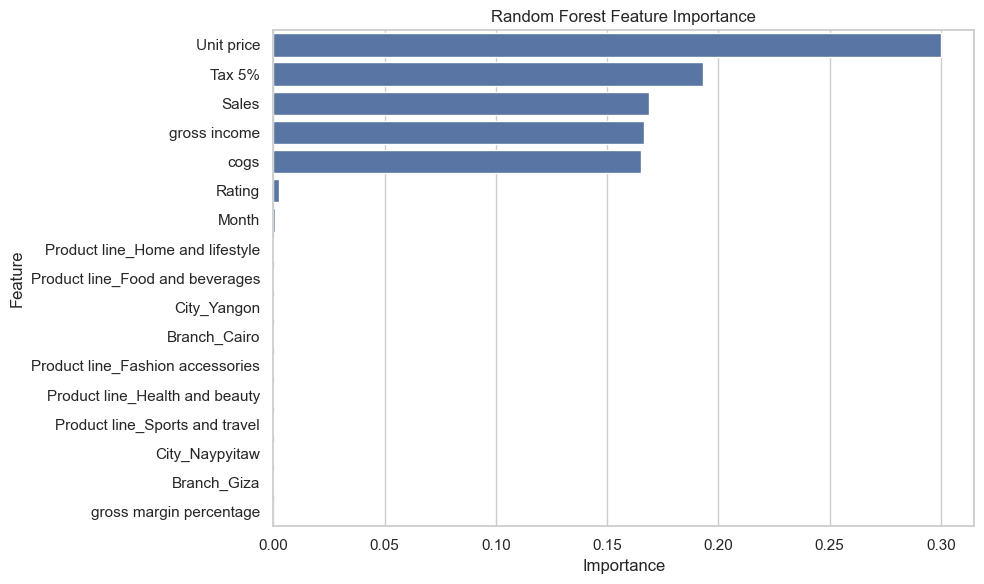

In [37]:
# Feature Importance for Random Forest
rf_model = models['Random Forest']
importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

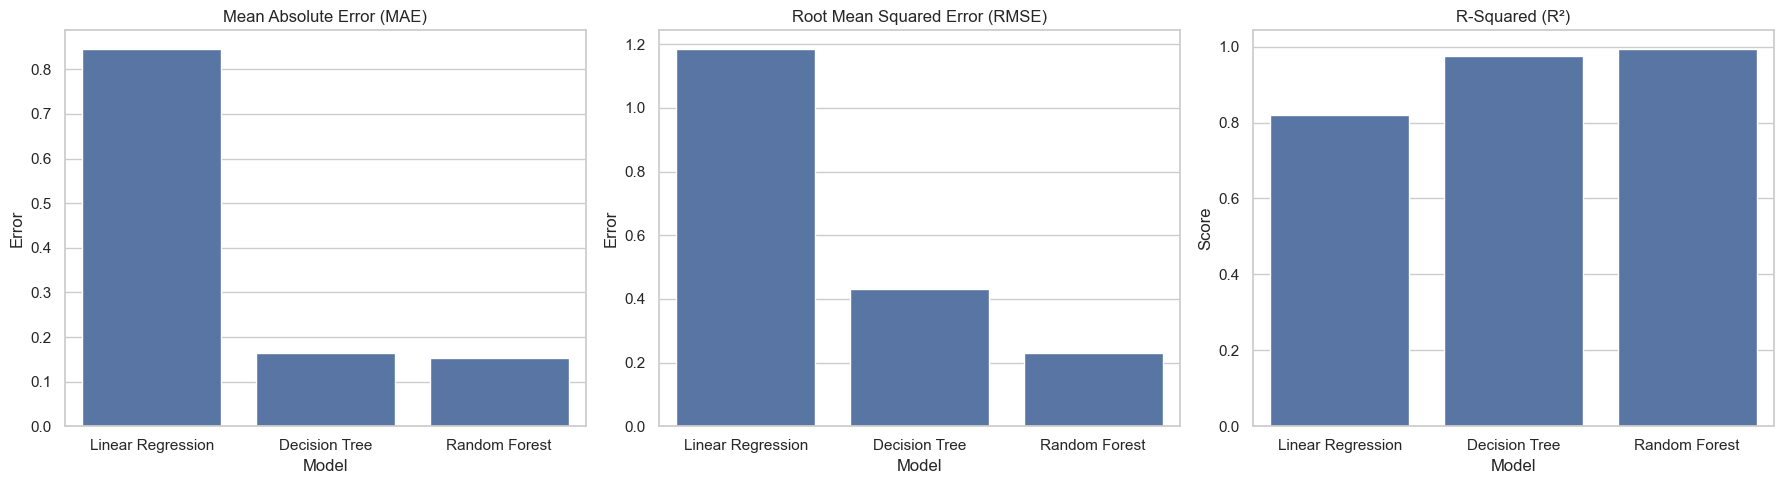

In [10]:
# Model performance data
model_results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest'],
    'MAE': [0.845, 0.165, 0.152],
    'RMSE': [1.184, 0.430, 0.229],
    'R^2': [0.820, 0.976, 0.993]
})

# Set plot style
sns.set(style="whitegrid")

# Create subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE
sns.barplot(x='Model', y='MAE', data=model_results, ax=axes[0])
axes[0].set_title('Mean Absolute Error (MAE)')
axes[0].set_ylabel('Error')

# RMSE
sns.barplot(x='Model', y='RMSE', data=model_results, ax=axes[1])
axes[1].set_title('Root Mean Squared Error (RMSE)')
axes[1].set_ylabel('Error')

# R^2
sns.barplot(x='Model', y='R^2', data=model_results, ax=axes[2])
axes[2].set_title('R-Squared (R²)')
axes[2].set_ylabel('Score')

plt.tight_layout()
plt.show()

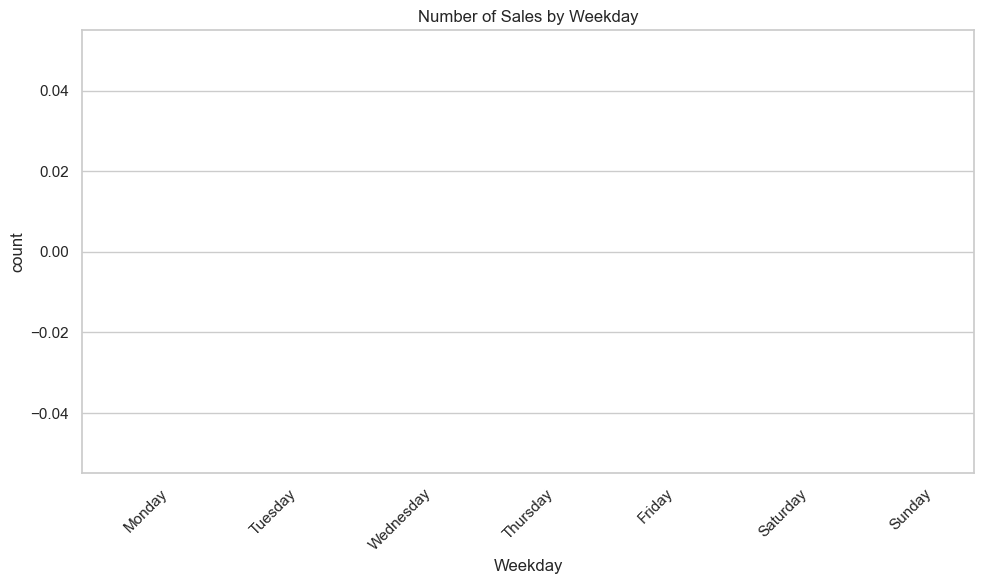

C:\Users\ashle\AppData\Local\Temp\ipykernel_10576\3647931919.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Product line', y='Rating', estimator=np.mean, ci=None)


ValueError: Could not interpret value `Product line` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

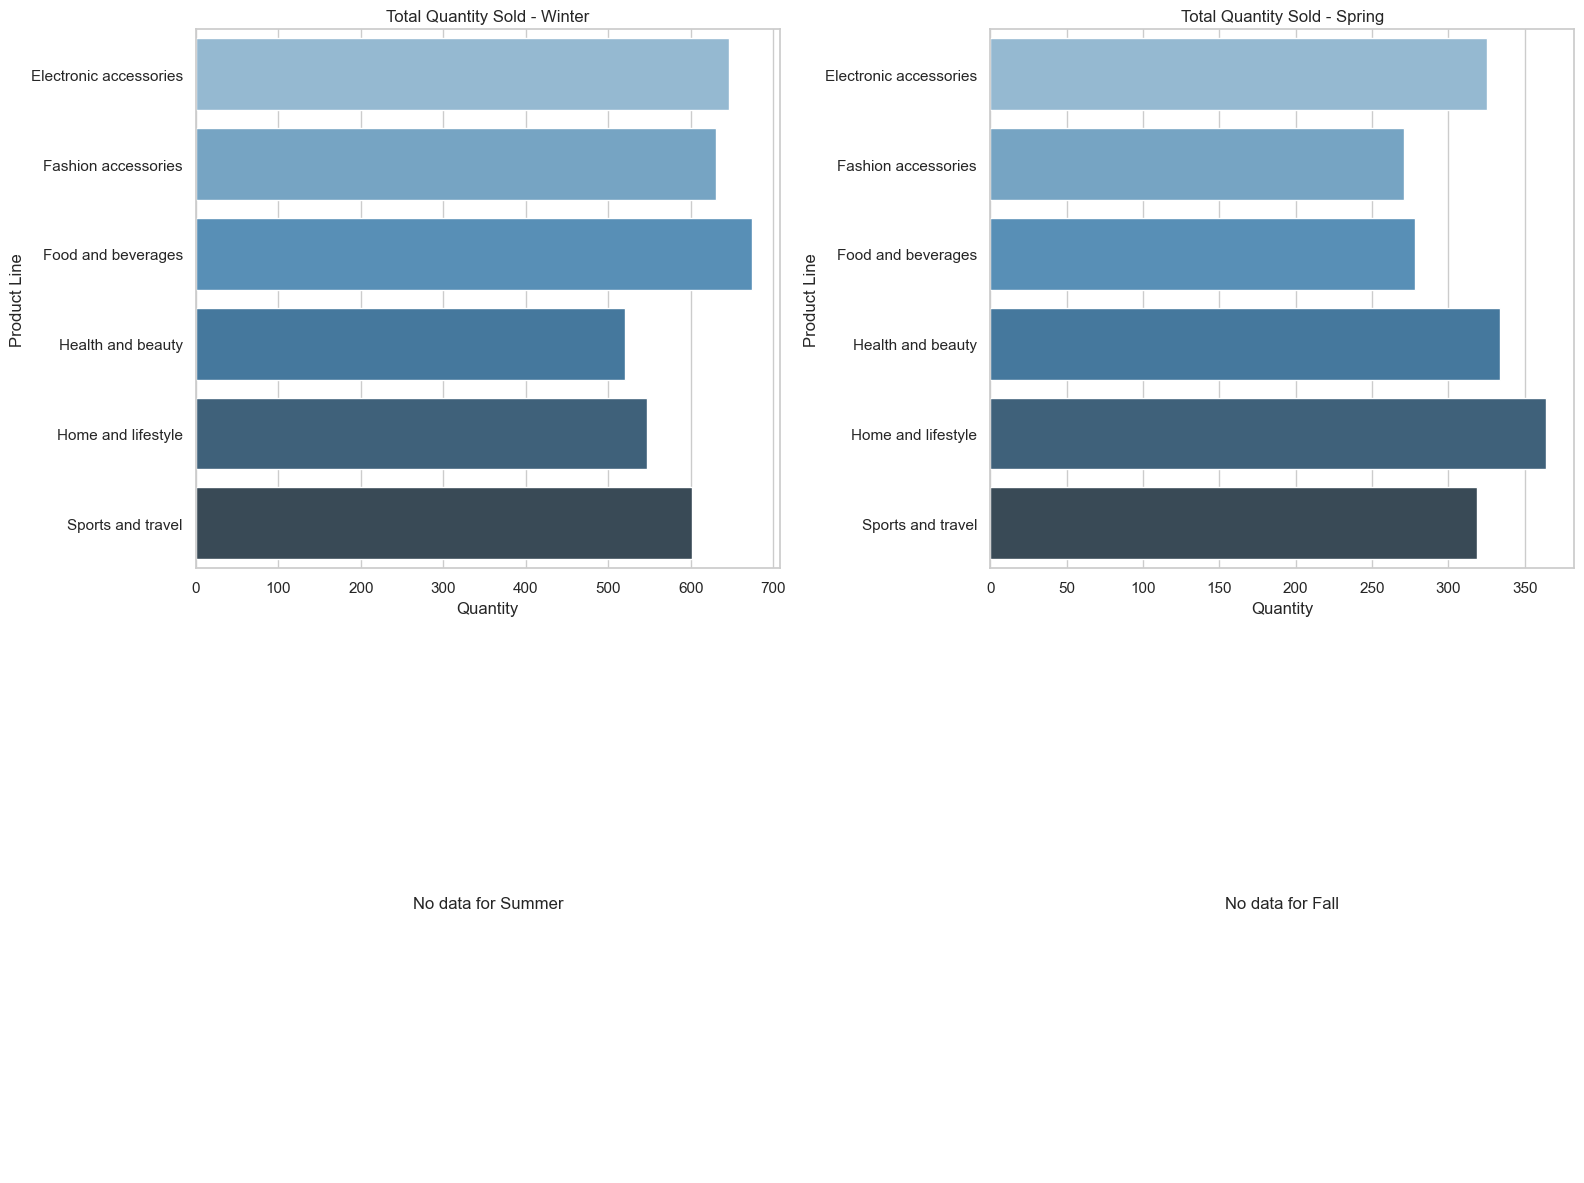

In [11]:
# Group by Season and Product line
seasonal_quantity = df.groupby(['Season', 'Product line'])['Quantity'].sum().reset_index()

# Ensure consistent season order
season_order = ['Winter', 'Spring', 'Summer', 'Fall']

# Plotting 2x2 seasonal charts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, season in enumerate(season_order):
    data = seasonal_quantity[seasonal_quantity['Season'] == season]
    
    if not data.empty:
        sns.barplot(data=data, x='Quantity', y='Product line', hue='Product line', ax=axes[i], palette='Blues_d', legend=False)
        axes[i].set_title(f'Total Quantity Sold - {season}')
        axes[i].set_xlabel('Quantity')
        axes[i].set_ylabel('Product Line')
    else:
        axes[i].text(0.5, 0.5, f'No data for {season}', ha='center', va='center')
        axes[i].set_axis_off()

plt.tight_layout()
plt.show()

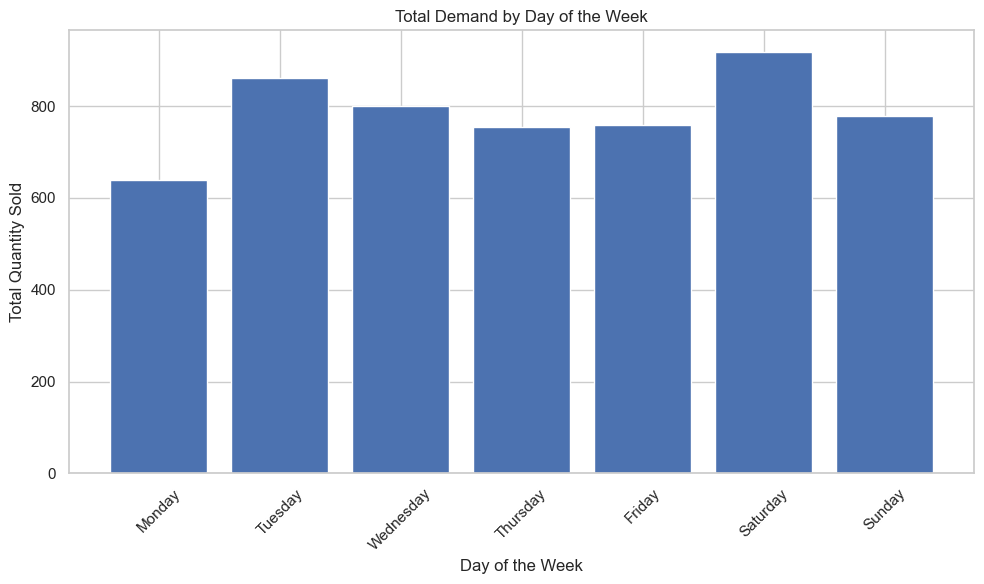

In [12]:
# Group by day of week and sum the quantity sold
demand_by_day = df.groupby('DayOfWeek')['Quantity'].sum()

# Reorder the days
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
demand_by_day = demand_by_day.reindex(ordered_days)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(demand_by_day.index, demand_by_day.values)
plt.title('Total Demand by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()